## PROCESSAMENTO DE IMAGENS 

**Objetivos da aula:**

*   apresentar e aplicar ao algoritimo de Watershed

ref: https://github.com/bnsreenu/python_for_microscopists/blob/master/033-grain_size_analysis_using_wateshed_segmentation.py


**O NOSSO PROBLEMA**

Como segmentar objetos semelhantes que estão se tocando?



Até o momento, os objetos estão bem separados uns dos outros, neste caso o metodo de segmentação de contorno funciona muito bem. E para o caso abaixo?


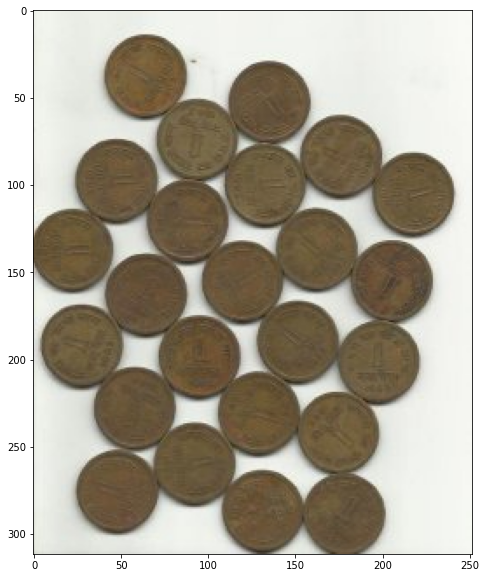

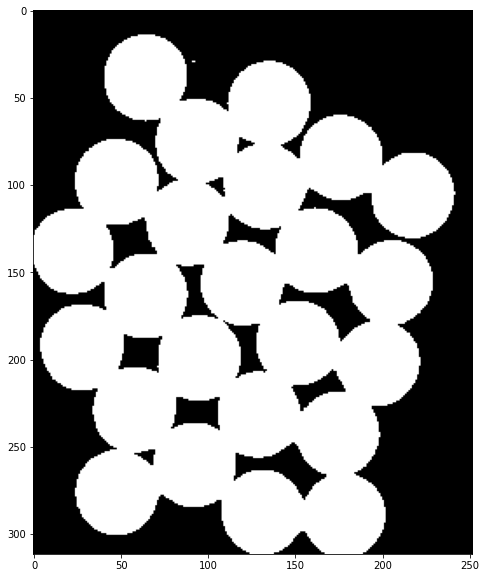

In [1]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import numpy as np

img = cv2.imread('water_coins.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (10,10))
plt.imshow(img_rgb); plt.show();

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.figure(figsize = (10,10))
plt.imshow(thresh,cmap="gray"); plt.show();

**Algoritmo de Watershed**

Em casos como esse, podemos usar o algoritmo de watershed, uma intuição de como funciona este algotimo é a seguinte. 

Queremos isolar regiões da imagem, para isso vamos imaginar uma imagem como um relevo (imagem topografica), que tem altos e baixos, a intensidade do pixel determina sua altura, o top ou vale. A teoria e a matemática por trás são complexas, mas por temos uma receita de bolo que costuma dar certo. 


<img src="watershed-lines.jpg">



**Prós e contras**

Vantagem, conseguimos seguimentar uma imagem em escala de cinza em mais do que duas regiões. Mesmo sendo objetos sobrepostos, conseguimos determinar sua fronteira.

Como desvantagem temos um problema de inicialização, se for aleatório ou mal inicializada, pode gerar resultado ruim.

Na OpenCV, temos uma função built-in que implementa o algoritimo de watershed:

    cv2.watershed(image, markers)
    
    image: imagem de entrada
    
    markers: são sementes "seeds", ou seja, onde nasce um objeto. É uma imagem do mesmo tamanho da imagem original, mas com regioẽs de interesse delineadas, cada região é equivalente a um centro objeto da imagem, nas bordas das regioẽs o valor da semente é -1.
    

**Como determinar os markers**

    1 - Determine a área da imagem que é o fundo certo (sure background area)
    2 - Encontre uma area em primeiro plano (find sure foreground area)
    3 - A diferença entre as duas areas (sure_bg -sure_fg) é uma região desconhecida pois é onde está a borda.
    4 - Rotule as regiões, o fundo da imagem com 0 e outros objetos são rotulados com números inteiros a partir de 1.

Simples assim...:)


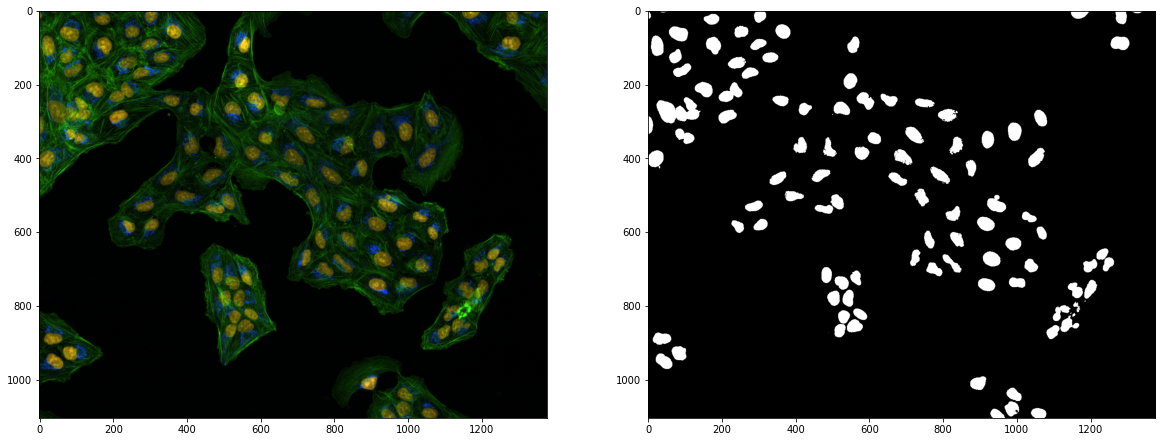

In [73]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import numpy as np

img = cv2.imread('Osteosarcoma_01.tif')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cells=img_rgb[:,:,2]  #usando a cor azul, pega melhor o contorno (para esse exemplo de imagem)
_, thresh = cv2.threshold(cells, 0, 255, cv2.THRESH_OTSU) ## limiarização


plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1); plt.imshow(img,cmap="gray")
plt.subplot(1, 2, 2);plt.imshow(thresh,cmap="gray"); plt.show();

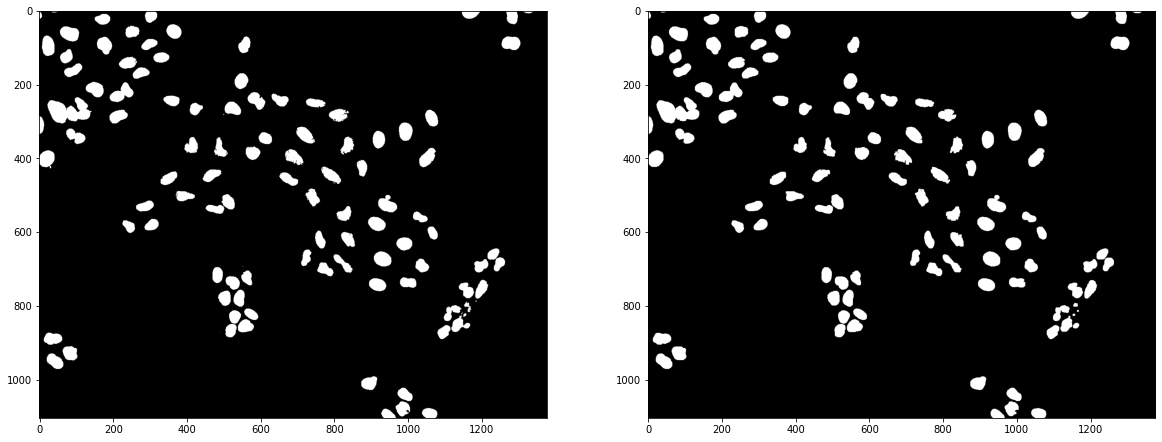

In [74]:
# vamos realizar o pre-processamento da imagem, limpando os ruidos e tapando buracos da imagem
# podemos usar morfologia ou qualquer outro processo.

kernel = np.ones((3,3),np.uint8) # matriz de convolução 3x3

opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2) ##morfologia para remover ruidos

plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1); plt.imshow(thresh,cmap="gray")
plt.subplot(1, 2, 2);plt.imshow(opening,cmap="gray"); plt.show();

Vamos fazer um teste usando o que já conhecemos para contar usando o findcontours(), note que a contagem não está correta, pois existe sobreposição na imagem. 


Foram identificados 109 contornos


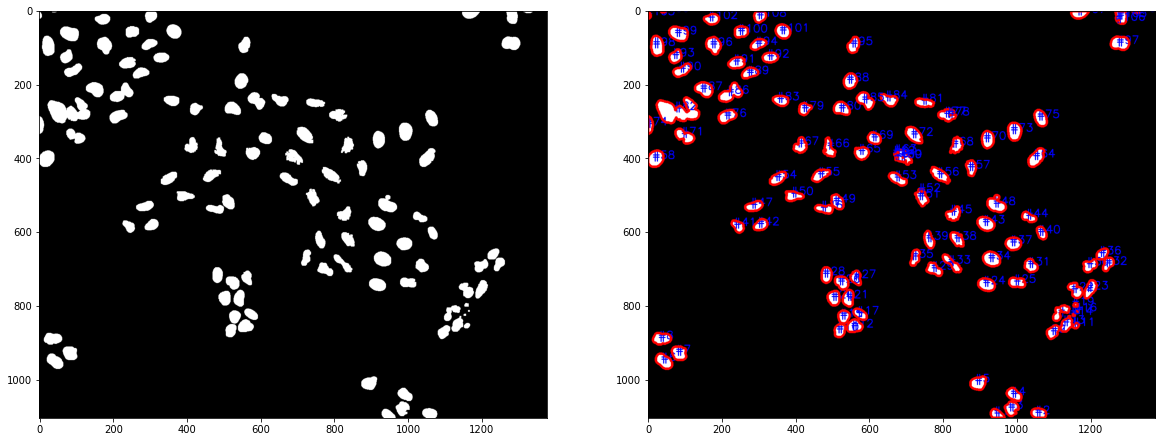

In [75]:

contornos, _ = cv2.findContours(opening, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 

opening_rgb = cv2.cvtColor(opening, cv2.COLOR_GRAY2RGB) 
contornos_img = opening_rgb.copy() # Cópia da máscara para ser desenhada "por cima"



for (i, c) in enumerate(contornos):
    # draw the contour
    ((x, y), _) = cv2.minEnclosingCircle(c)  ## truque para pegar as coordenadas de centro x,y de cada contorno
    cv2.putText(contornos_img, "#{}".format(i + 1), (int(x) - 10, int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    cv2.drawContours(contornos_img, [c], -1, [255, 0, 0], 5);

print("Foram identificados",len(contornos),"contornos")


plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1); plt.imshow(opening,cmap="gray")
plt.subplot(1, 2, 2);plt.imshow(contornos_img); plt.show();

Vamos aplicar a transformada de **Watershed**. Para isso vamos seguir o proprio exemplo de aplicação da técnica e adaptar para a nosso exemplo.

REF: https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_watershed/py_watershed.html 


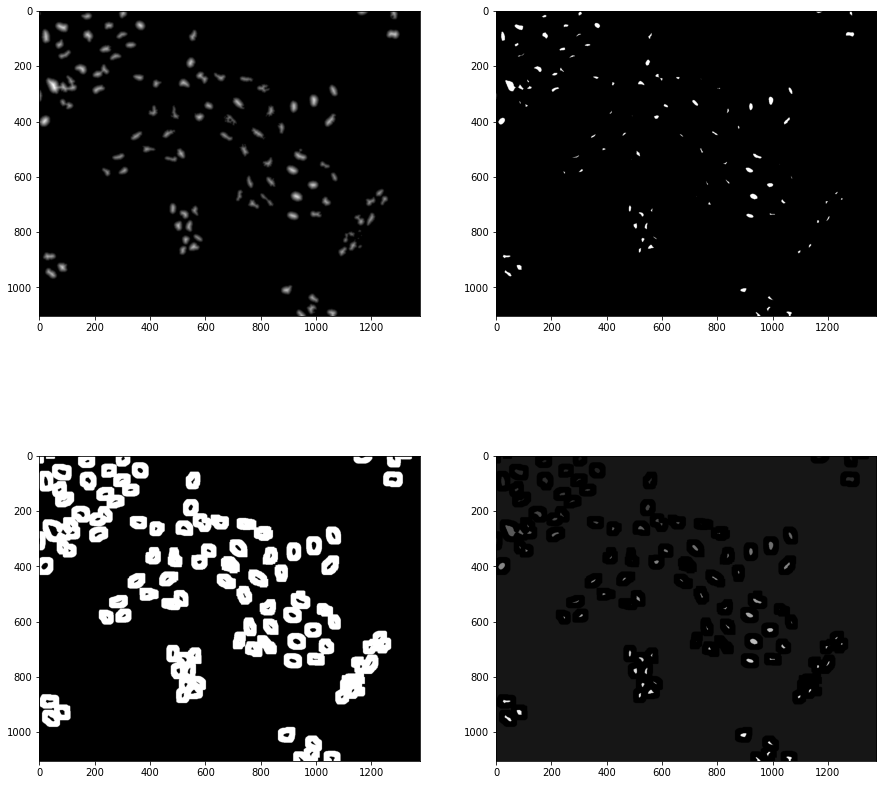

In [70]:
# agora que já sabemos onde estão os centros das celulas, determinamos uma área de fundo certo (sure background area)

sure_bg = cv2.dilate(opening,kernel,iterations=10)

# Determinamos uma área segura em primeiro plano (Finding sure foreground area)
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)


# Buscamos regiões desconhecidas (Finding unknown region)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg) 


# Rotulando o marcador
ret, markers = cv2.connectedComponents(sure_fg)


# Adicione 1 a todos os marcadores para garantir que o plano de fundo não seja 0, mas 1
markers = markers+10

# Agora, marque a região desconhecida com zero
markers[unknown==255] = 0 


plt.figure(figsize=(15,15))
plt.subplot(2, 2, 1);plt.imshow(sure_bg,cmap="gray")
plt.subplot(2, 2, 2);plt.imshow(sure_fg,cmap="gray")
plt.subplot(2, 2, 3);plt.imshow(unknown,cmap="gray")
plt.subplot(2, 2, 4); plt.imshow(markers,cmap="gray"); plt.show();

(1104, 1376)


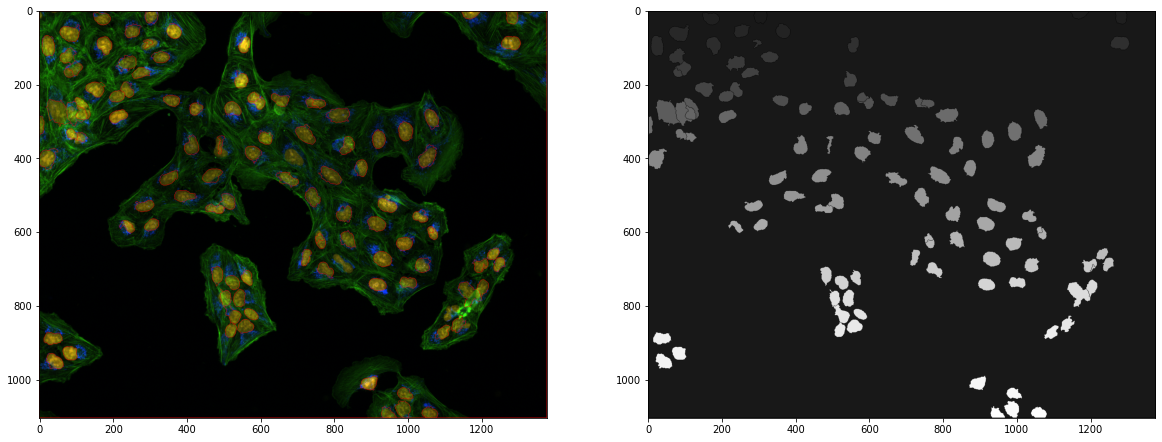

In [72]:
#Agora podemos aplicar watershed. 
markers = cv2.watershed(img,markers)

# cada contorno fica vermelho
img[markers == -1] = [255,0,0]  

print(markers.shape)

plt.figure(figsize=(20,20))
plt.subplot(1, 2, 2); plt.imshow(markers,cmap="gray")
plt.subplot(1, 2, 1);plt.imshow(img); plt.show();



Foram identificados 103 contornos


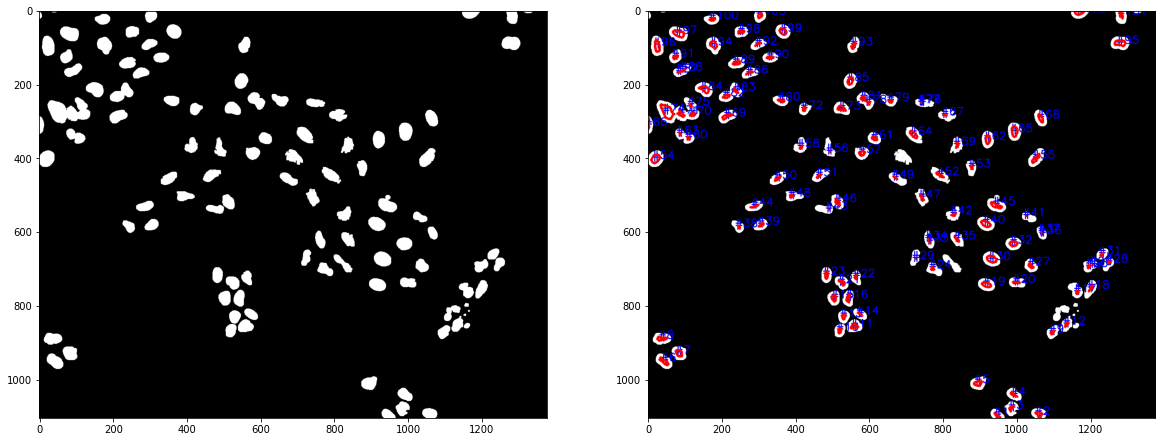

In [71]:
contornos, _ = cv2.findContours(sure_fg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 

opening_rgb = cv2.cvtColor(opening, cv2.COLOR_GRAY2RGB) 
contornos_img = opening_rgb.copy() # Cópia da máscara para ser desenhada "por cima"

for (i, c) in enumerate(contornos):
    # draw the contour
    ((x, y), _) = cv2.minEnclosingCircle(c)  ## truque para pegar as coordenadas de centro x,y de cada contorno
    cv2.putText(contornos_img, "#{}".format(i + 1), (int(x) - 10, int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    cv2.drawContours(contornos_img, [c], -1, [255, 0, 0], 5);

print("Foram identificados",len(contornos),"contornos")


plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1); plt.imshow(opening,cmap="gray")
plt.subplot(1, 2, 2);plt.imshow(contornos_img); plt.show();

## Exercicio

Faça a segmentação das moedas utilizando o algoritmo de watershed


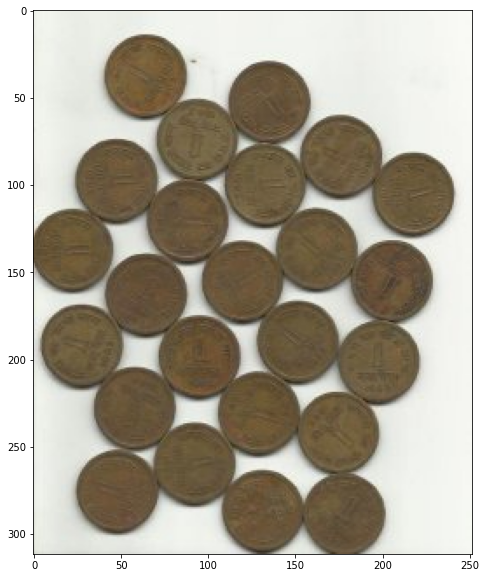

In [9]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import numpy as np

img = cv2.imread('water_coins.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


plt.figure(figsize = (10,10))
plt.imshow(img_rgb); plt.show();

In [10]:
#implemente sua solução aqui..



